# Naive Bayes Classifier

This notebook is a companion to [Note 21, Inference](http://www.eecs70.org/static/notes/n21.pdf) of the [CS70](http://www.eecs70.org) lecture notes. Much of this notebook is a paraphrase of the material presented in the original note, along with my own annotations and live code examples.

Trying to classify digits by trying to teach a computer specific rules about what a $1$ or a $2$ looks like is difficult and does not scale well. Try writing a $5$ multiple times on a piece of paper, do they all appear exactly the same? It is difficult to classify your own handwriting, let alone classify the handwriting of some arbitrary person. Instead we will use probability theory, specifically Bayes Rule, to build a simple classifier.

# Overview
$\newcommand{\argmax}[1]{\underset{#1}{\operatorname{arg}\,\operatorname{max}}\;}$
For each digit $j \in \{0,1,...9\}$, we define the probability distribution $P_j(x)$. I will clarify this notation soon. If we treat image classification as a balls and bins problems, it's clear that there are $10$ bins, each labeled some $j$. The balls in each bin are the images of the digit corresponding to that particular bin.

 ![balls_bins](images/balls_bins.png)
 
Each of these bins is labeled "prior $\pi_j$" because the distribution $P(y=j) = \pi_j,\,j \in \{0,1,...9\}$ is known as a the "prior distribution". It represents our current understanding of the scenario. It may not be clear where this distribution comes from, we will address that soon. It may be clear now, that classification is the same as a balls and bins problem where we are given a ball and we need to guess which bin it came from.

## Classification as inference
 
We can rewrite $P_j(x) = P(x\mid y=j)$ which translates to "the probability of generating image $x$ given that bin label $y$ is $j$". In other words it's the probability that a machine will generate image $x$ of digit $j$. It is not clear where $P_j(x)$ comes from either, but we will address that soon. However, we do have all the necessary components to answer the question, "Given image $x$, what's the probability that bin label $y$ is $j$?". Convince yourself that answering this question answers the digit classification problem.

\begin{align*}
    P(y=j \mid x) = \frac{P(y=j, x)}{P(x)} = \frac{P(x \mid y=j) \cdot P(y=j)}{P(x)} = \frac{\pi_jP_j(x)}{P(x)} = \frac{\pi_jP_j(x)}{\sum_{i=0}^9 P(x, y=i)} = \frac{\pi_jP_j(x)}{\sum_{i=0}^9 P(x|y=i)P(y=i)} = \frac{\pi_jP_j(x)}{\sum_{i=0}^9 P_i(x)\pi_i}
\end{align*}

The third inequality uses Bayes Rule and the fifth inequality uses the Law of Total Probability.

Now, all we have to do is find the digit $j$ that maximizes the probability $P(y=j \mid x)$. Note that $P(y=j \mid x)$ is the *posterior* distribution. It represents the knowledge we have after using the Bayes Rule with the *prior* distribution $P(y=j)$. Let $h(x)$ be the digit we predict given image $x$.

\begin{align*}
h(x) &= \arg\max_{j} \pi_jP_j(x) \\
     &= \arg\max_{j} \frac{\pi_jP_j(x)}{\sum_{i=0}^9 P_i(x)\pi_i} \\
     &= \arg\max_{j} \pi_jP_j(x)
\end{align*}

This syntax means "$h(x)$ is the argument $j$ which maximizes $\pi_jP_j(x)$". Note that the denominator for $P(y=j \mid x)$ does not depend on $j$ so we don't need to consider it when maximizing $j$. This is called the *maximum a posteriori* (MAP) estimator.

We now have formal mathematical model for inferring a digit $h(x)$ given an image $x$. Now, all we have to do is find a way to compute $\pi_j$ (prior distribution) and $P_j(x)$ (conditional distribution).

# Estimating the Prior Distribution

Given a data set of $n$ $(x,y)$ pairs where $x$ is an image and $y$ is the corresponding label (digit), we can "train" the model to provide accurate probability estimations of each digit, given an image. Training is essentially estimating $P(y=j) = \pi_j$, the prior distribution, and estimating $P(x \mid y=j) = P_j(x)$, the conditional distribution.

Let $n$ be the number of training samples. Let $n_j$ be the number of training samples that are digit $j$.

\begin{align*}
\hat{\pi}_j = \frac{n_j}{n}
\end{align*}

The two requirements a probability distribution must fulfill are:

1. The probabilities must sum up to $1$

2. Every probability $p$ produced by the distribution must be $0 \leq p \leq 1$

We can verify that $\hat{\pi}_j$ is a valid probability distribution. If $n_j$ represents the number samples where digit $j$ appears, then $n_0 + n_1 + ... n_9 = n$, since there are $9$ disjoint subsets of $n$, each with cardinality $n_j$. Due to this fact, convince yourself that $\hat{\pi_0} + \hat{\pi_1} + ... \hat{\pi_9} =1$.

In [15]:
import mnist
import pickle

# Load the training data as a tuple (label, image) where image is a 2D numpy matrix
training_data = mnist.read(dataset='training', path='./data')

def compute_prior(training_data):
    """
    Generates the prior distribution using training_data
    @param training_data The training set provided by the MNIST database
    @return A dictionary mapping a digit to the probability that the digit appears in the training set. For example,
    prior_distribution[j] = the probability that the digit j appears in the MNIST training set for j in [0,9]
    """
    # The number of times we see each label
    label_counts = {}
    # The total number of images in the training set
    n = 0
    # The prior distribution we will compute
    prior_distribution = {}

    for pair in training_data:
        label, image = pair
        n+=1
        # Increment label_counts[label] for all 0,..., 9 labels
        if label in label_counts:
            label_counts[label]+=1
        else:
            label_counts[label] = 1
    
    for i in range(10):
        # Compute the estimation of the prior distribution for all 0, ..., 9 labels
        prior_distribution[i] = float(label_counts[i]) / n
    
    return prior_distribution
    
prior_distribution = compute_prior(training_data)
pickle.dump(prior_distribution, open("./data/prior_distribution.p", "wb"))
print(prior_distribution)

{0: 0.09871666666666666, 1: 0.11236666666666667, 2: 0.0993, 3: 0.10218333333333333, 4: 0.09736666666666667, 5: 0.09035, 6: 0.09863333333333334, 7: 0.10441666666666667, 8: 0.09751666666666667, 9: 0.09915}


# Estimating the Conditional

As a reminder we are trying to compute $P_j(x) = P(x \mid y=j)$, the probability that we generate an image $x$ given that the bin label $y$ is $j$. Each image in the MNIST data set is a 2D matrix with $28$ rows and $28$ columns. We can flatten each of these images into a single dimensional vector with $784$ components. You can think of each image $x$ living in $784$-dimensional space, and each $x$ is a point in that space.

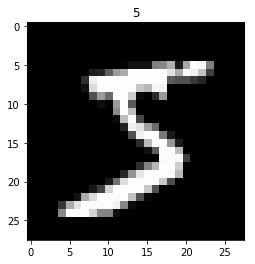

In [10]:
import mnist
import matplotlib.pyplot as plt
training_data = mnist.read(dataset='training', path='./data')
label, image = training_data.__next__()
plt.title(label)
plt.imshow(image, cmap='gray')
plt.show()

As you can see, each pixel $x_i \in \{0, ..., 255\}$ because this is a 8-bit grayscale image. Since we will eventually be dealing with probabilities it will be easier to deal with grayscale images where $x\in [0,1]^{784}$ and each pixel $x_i \in [0,1]$. Furthermore, we can threshold the the image by setting each $x_i=1$ if $x_i \geq \frac{1}{2}$ and $x_i=0$ otherwise. This method is known as *binarization* of an image. This gives us the ability to treat each pixel $x_i$ as a Bernoulli random variable, or indicator random variable, since they can only take on values $1$ or $0$. This gives us an image $x \in \{0,1\}^{784}$ and $x_i \in \{0,1\}$. Note the difference between the square brackets in the first sentence and the curly brackets in the previous sentence.

Here's where the "naive" part comes in. We can treat each pixel in the image of a digit as independent random variables. Recall that if two events $A$ and $B$ are independent, $P(A \cap B) = P(A)P(B)$. We can use this very simple fact to make the computation of $P_j(x)$ very easy.

\begin{align*}
P_j(x) = P_{j1}(x_1) \cdot P_{j2}(x_2) \cdot \cdot \cdot P_{j,784}(x_{784})
\end{align*}

We can parameterize $P_j(x)$ with only $784$ values as opposed to $2^{784}$ values if we didn't make the assumption that each pixel $x_i$ was independent. Let $P_{ji}(x)$ be the probability that the $i$-th pixel of digit $j$ is $1$.

\begin{align*}
P_{ji}(x_i=1) = p_{ji} \\
P_{ji}(x_i=0) = 1-p_{ji} \\
P_{ji}(x_i) = p^{x_i}_{ji}(1-p_{ji})^{1-x_i}, \,x_i \in \{0,1\}
\end{align*}

Now it is more clear that $x_i \sim Ber(p_{ji})$ and $P_j(x)$ is just a product of $784$ independent random variables. More importantly, it represents the probability that pixels that are "on", or take on the value $1$ form the digit $j$.

Let $n$ be the number of training samples. Let $n_j$ be the number of samples with digit $j$. Let $n_{ji}$ be the number of samples of digit $j$ that have the pixel $x_i=1$.

\begin{align*}
\hat{p}_{ji} = \frac{n_{ji}}{n_j}
\end{align*}

This is the estimated probability of the $i$-th pixel in digit $j$ being $1$. This estimation is computed directly from the training data. There's a small problem with this though. If $n_{ji} = 0$, or we see no images of digit $j$ with the $i$-th pixel equal to $1$, then $\hat{p}_{ji}$ will be $0$. Similarly if all training images of digit $j$ have the $1$ in the $i$-th pixel, then $n_{ji} = n_j$, so $\hat{p}_{ji}$ will be $1$. Although this is representative of our current training samples, this may not represent an image we have not seen before. To account for this, we will artificially add two training images to the set. One with $x_i=0$ and $x_i=1$.

\begin{align*}
\hat{p}_{ji} = \frac{n_{ji} + 0 + 1}{n_j + 2} \\
\tilde{p}_{ji} = \frac{n_{ji}+1}{n_j + 2}
\end{align*}

$\newcommand{\argmax}[1]{\underset{#1}{\operatorname{arg}\,\operatorname{max}}\;}$

Recall the $h(x) = \arg\max_{j} \pi_jP_j(x)$ and we were trying to find $\pi_j$ and $P_j(x)$. We have found both, so we can start rewriting this equation in more concrete terms.

\begin{align*}
P_j(x) = \prod_{i=0}^{783} P_{ji}(x_i) = \prod_{i=0}^{783} p^{x_i}_{ji}(1-p_{ji})^{1-x_i}
\end{align*}

\begin{align*}
h(x) &= \arg\max_{j} \pi_jP_j(x)\\
      &= \arg\max_{j} \pi_j \prod_{i=0}^{783} p^{x_i}_{ji}(1-p_{ji})^{1-x_i}
\end{align*}


"Underflow" occurs when a computer cannot represent a floating point number beyond some specified precision. Multiplying a several small decimals together (ie. probabilities), can cause this. Estimating $h(x)$ above will cause Python to error out. Instead, we will maximize the function below. The logarithm has the effect of taking a decimal $d$ and outputing $-\frac{1}{d}$ which produces numbers with a whole number part and a decimal part, avoiding underflow. The important part is that even though the maximums for each $j \in \{0, ..., 9\}$ will be different, the $j$ that maximizes $h(x)$ will be the same, because $log$ is a monotonically increasing function.

\begin{align*}
h(x) &= \arg\max_{j} log(\pi_jP_j(x)) \\
     &= \arg\max_{j} log(\pi_j \prod_{i=0}^{783} p^{x_i}_{ji}(1-p_{ji})^{1-x_i}) \\
     &= \arg\max_{j} log(\pi_j) + log(p^{x_0}_{j0}) + log((1-p_{j0})^{1-x_0}) + ... + log(p^{x_{783}}_{j783}) + log((1-p_{j783})^{1-x_{783}}) \\
     &= \arg\max_{j} log(\pi_j) + x_0log(p_{j0}) + (1-x_0)log(1-p_{j0}) + ... + x_{783}log(p_{j783}) + (1-x_{783})log(1-p_{j783}) \\
     &= \arg\max_{j} log(\pi_j) + \sum_{i=0}^{783} (x_i\,log\,p_{ji} + (1-x_i)log(1-p_{ji}))
\end{align*}

Below is a program to compute the pixel probabilities $\tilde{p}_{ji}$ for all $i \in \{0, ..., 783\}$ for all $j \in \{0, ..., 9\}$. This program will take a while to run depending on your processor clock speed, which is why this notebook comes with the pre-computed distributions in `data/pixel_probabilities.p`.

In [16]:
# Some common image processing functions

def normalize_image(image):
    """
    Normalizes a flattened image
    @param image A flattened image
    """
    image = 1/255 * image

def binarize_image(image):
    """
    Applies a fixed threshold on a flattened image. For each pixel x_i, 
    x_i = 1 if x_i >= 1/2 and x_i = 0 otherwise
    @param image A flattened image
    """
    for i in range(0, len(image)):
        if image[i] >= 0.5:
            image[i] = 1
        else:
            image[i] = 0

In [13]:
import mnist
import numpy as np
import pickle

training_data = mnist.read(dataset='training', path='./data')

def estimate_pixel_probabilities(training_data):
    """
    Generates the pixel probabilities using training_data
    @param training_data The training set provided by the MNIST database
    @return A dictionary mapping a digit to an array of pixel probabilities. For example, 
    pixel_probabilities[j][i] = probability that the i-th pixel is 1 in the j-th digit for j in [0,9] and i in [0,783]
    """
    # pixel_counts[j][i] = number of times the i-th pixel is 1 in the j-th digit for j in [0,9] and i in [0,783]
    pixel_counts = {}
    # pixel_probabilities[j][i] = probability that the i-th pixel is 1 in the j-th digit
    pixel_probabilities = {}
    # label_counts[j] = number of times digit j appears in the training set
    label_counts = {}
    # the prior distribution generated in compute_prior()
    prior_distribution = pickle.load(open('./data/prior_distribution.p', 'rb'))
    
    # Compute the pixel_counts and label_counts for every digit in the training set
    for pair in training_data:
        label, _image = pair
        image = _image.flatten()
        normalize_image(image)
        binarize_image(image)
            
        if label not in label_counts:
            label_counts[label] = 1
        else:
            label_counts[label]+=1
            
        if label not in pixel_counts:
            pixel_counts[label] = [0] * 784
        
        for i in range(len(image)):
            if image[i] == 1:
                pixel_counts[label][i] +=1
    
    # Compute the pixel_probabilities using label_counts and pixel_counts
    for j in range(10):
        n_j = label_counts[j]
        pixel_probabilities[j] = [0] * 784
        for i in range(784):
            n_ji = pixel_counts[j][i]
            p_ji = float(n_ji + 1) / (n_j + 2)
            pixel_probabilities[j][i] = p_ji

    return pixel_probabilities

pixel_probabilities = estimate_pixel_probabilities(training_data)
pickle.dump(pixel_probabilities, open("./data/pixel_probabilities.p", "wb"))

# Validation

The MNIST data comes with a set of test imagery $(x', y')$ where $x'$ is an image that is not in the training set, and $y'$ is its corresponding label. We can measure the accuracy of our MAP estimator by seeing how many of the $x'$ images we classify correctly. But first, we must first code our MAP estimator. Since we have computed the prior distribution and the pixel probabilities for each digit, we just have to compute the conditional probability given an image and find the digit $j$ that maximizes their product.

In [18]:
import mnist
import pickle
from math import log

prior_distribution = pickle.load(open("./data/prior_distribution.p", "rb"))
pixel_probabilities = pickle.load(open("./data/pixel_probabilities.p", "rb"))

def estimate_digit(image):
    """
    Given a (28,28) grayscale image, estimates which digit [0,...,9] is written in it
    @param image A (28,28) grayscale image
    @return The digit [0,...,9] which is most likely to be written inside of the image
    """
    image = image.flatten()
    normalize_image(image)
    binarize_image(image)
    best_digit = None
    best_max = None
    
    # h(x) function, but in code
    # Since we are working over a small discrete space [0,...,9], we can simply
    # loop through all 10 digits and see which digit maximizes h(x)
    for j in range(10):
        s = log(prior_distribution[j])
        for i in range(len(image)):
            x_i = image[i]
            p_ji = pixel_probabilities[j][i]
            s+= x_i * log(p_ji) + (1-x_i) * log(1-p_ji)
        if best_max is None or s > best_max:
            best_max = s
            best_digit = j
    return best_digit

In [11]:
test_data = mnist.read(dataset='testing', path='./data')

def measure_accuracy(test_data):
    correct = 0
    total = 0
    for pair in test_data:
        label, image = pair
        if (estimate_digit(image)) == label:
            correct+=1
        total+=1
        print('.')
    return float(correct) / total

accuracy = measure_accuracy(test_data)
print(accuracy)


Whether you take my word, or run the above cell, the accuracy of the MAP estimator on the MNIST dataset is $0.8413$ or $84.13\%$ which is close to the accuracy reported in Note 21, $84.6\%$. The difference is likely due to how different programming languages handle floating point multiplication and division, but that's just a guess. Intuitively it means that $8,413$ out of $10,000$ test images were classified correctly. The MAP estimator gets a B in accuracy, but it's very easy to implement and run compared to more sophisticated techniques like neural networks.